In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import shutil
import socket
import os

## Extract data

In [3]:
hostname = socket.gethostname()
if hostname == "HAITI":
    repo_folder = "C:/Users/xin/OneDrive - bwstaff/xin/yolov7/"
    dataset_folder = "D:/xin/datasets/CV/pictor-ppe/"
if hostname == "BALI":
    repo_folder = "/home//OneDrive/xin/yolov7/"
    dataset_folder = "/storage/xin/datasets/CV/pictor-ppe/"

dataset_folder_original = dataset_folder + "original_format/"

In [4]:
val_file = os.path.join(dataset_folder_original ,"Labels", "pictor_ppe_crowdsourced_approach-03_train.txt")
with open(val_file) as f:
    lines = f.readlines()
lines[0]

'image_from_china(1).jpg\t992,366,1040,511,0\t817,360,831,400,0\t860,366,879,386,0\n'

## Show format

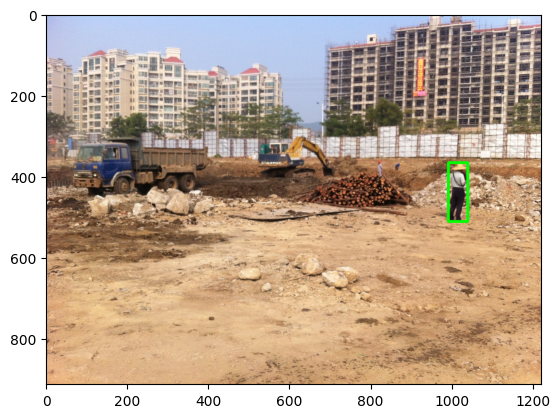

In [4]:
# pictor-ppe originally records top-left and bottom-right coordinates
img_path = os.path.join(dataset_folder_original ,"Images", "image_from_china(1).jpg")
img = cv2.imread(img_path)
cv2.rectangle(img, (992,366),(1040,511), color = (0, 255, 0),thickness = 5)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
# but coco records center and size
with open('/storage/xin/datasets/CV/coco2017/labels/val2017/000000190140.txt') as f:
    val2017_000000190140 = f.readlines()
obj = val2017_000000190140[0].replace("\n","").split(' ')
img_path = os.path.join('/storage/xin/datasets/CV/coco2017/images/val2017', "000000190140.jpg")
img = cv2.imread(img_path)
height, width, channels = img.shape
xc = int(width * float(obj[1]))
yc = int(height * float(obj[2]))
w = int(width * float(obj[3]))
h = int(height * float(obj[4]))
cv2.rectangle(img, (xc-w//2,yc-h//2),(xc+w//2,yc+h//2), color = (0, 255, 0),thickness = 5)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

: 

## Rearange the data

In [7]:
def pictor_to_coco_format(label_file_txt, dataset_folder = dataset_folder):
    # train or val or test
    dataset_str = label_file_txt.split('_')[-1].replace('.txt','').replace('valid','val')

    # new dataset folder
    dataset_folder_images_new = os.path.join(dataset_folder, 'images',dataset_str)
    dataset_folder_labels_new = dataset_folder_images_new.replace('images','labels')
    if not os.path.exists(dataset_folder_images_new):
        os.makedirs(dataset_folder_images_new)
    if not os.path.exists(dataset_folder_labels_new):
        os.makedirs(dataset_folder_labels_new)


    # read from original label file
    dataset_folder_original = os.path.join(dataset_folder,'original_format')
    label_file_path = os.path.join(dataset_folder_original ,"Labels",label_file_txt )
    with open(label_file_path) as f:
        lines = f.readlines()

    txt_path_list = []
    jpg_path_list = []
    for i in range(len(lines)):
        line = lines[i].replace('\n','').split('\t')
        jpg_name = line[0]

        # copy jpg to new dst
        jpg_path_original = os.path.join(dataset_folder_original, 'Images', jpg_name)
        jpg_path = os.path.join(dataset_folder_images_new, jpg_name) # =dst
        jpg_path_list.append(jpg_path)
        shutil.copyfile(jpg_path_original, jpg_path)

        data = []
        for j in range(1, len(line)):
            obj = line[j].split(',')
            cls = obj[-1]

            img_path = os.path.join(dataset_folder_original ,"Images", line[0])
            img = cv2.imread(img_path)
            height, width, channels = img.shape

            x0 = float(obj[0])/width
            y0 = float(obj[1])/height
            x1 = float(obj[2])/width
            y1 = float(obj[3])/height

            w = x1 - x0
            h = y1 - y0
            xc = (x0 + x1)/2
            yc = (y0 + y1)/2

            # keep 6 digits as in coco
            w = round(w,6)
            h = round(h,6)
            xc = round(xc,6)
            yc = round(yc,6)

            s = f'{cls} {xc} {yc} {w} {h}'
            data.append(s)
        
        # write to new txt file
        txt_path = os.path.join(dataset_folder_labels_new, jpg_name.replace('.jpg','.txt'))
        txt_path_list.append(txt_path)
        with open(txt_path, 'w') as f:
            for datum in data:
                f.write(datum + '\n')

    # write all file locations to new txt file 
    with open(os.path.join(dataset_folder, dataset_str+'.txt'), 'w') as f:
        for jpg_path in jpg_path_list:
            f.write(jpg_path + '\n')        

In [8]:

# label_file_txt = "pictor_ppe_crowdsourced_approach-03_valid.txt"
# label_file_txt = "pictor_ppe_crowdsourced_approach-03_test.txt"
label_file_txt = "pictor_ppe_crowdsourced_approach-03_train.txt"
pictor_to_coco_format(label_file_txt)